# Nuages de mots

In [2]:
# ============================================================
# ANALYSE DE CORPUS — VERSION FINALE PROPRE
# ============================================================

import os
import re
from collections import Counter
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import numpy as np

# ------------------------------------------------------------
# Configuration
# ------------------------------------------------------------

data_path = "../../data/txt_tp4"
output_dir = "../../data/results/"
os.makedirs(output_dir, exist_ok=True)

# Téléchargement ressources NLTK si besoin
nltk.download("punkt", quiet=True)
nltk.download("stopwords", quiet=True)

True

In [3]:
# Stopwords français
sw = set(stopwords.words("french"))

# Stopwords personnalisés (journalisme, bruit thématique)
stopwords_custom = {
    "bruxelles","soir","matin","hier","demain","samedi","dimanche","lundi","mardi","mercredi",
    "jeudi","vendredi","rossel","belga","afp","programme","heures","etc","tout","comme","sans",
    "bien","tous","grand","fait","apres","donc","etre","tres","non","aussi","ans","sous","encore",
    "monde","faire","cours","trois","entre","avant","alors","meme","depuis","peu","fois","jours",
    "ainsi","dire","autre","annee","peut","part","toute","moins","bon","lieu","toutes",
    "ville","place","rue","quartier","gare","train","metro","bus","parking",
    "pays","gouvernement","ministre","election","parti","loi","decision",
    "temps","vie","homme","personne","groupe","cas","question","moment",
}

# MOTS CIBLES (jamais filtrés)
mots_cibles = {
    # Sorcellerie
    "sorciere","sorcieres","sorcier","sorciers","sorcellerie","magie","magique","sortilege",
    "envoûtement","demon","diable","sabbat","rituel","potion","malefice","exorcisme",
    # Feminisme
    "feminisme","feministes","mlf","sororite","emancipation","autonomie","woman","women",
    # Justice / persécution
    "proces","tribunal","accusation","torture","bucher","execution","chatiment","inquisition",
    "victime","aveu","aveux","chasse","persecution",
    # Folklore
    "macrale","tchestia","legende","mythe","conte","suprerstition",
    # Stigmatisation
    "hysterie","folie","demoniaque","heretique","maudite","satanique"
}


In [4]:
# ------------------------------------------------------------
# FONCTIONS
# ------------------------------------------------------------

def nettoyer_texte(t):
    t = re.sub(r"[^\w\s\-àâäéèêëîïôöùûüç]", " ", t)
    t = re.sub(r"\d+", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.lower().strip()

def filtrer_mots(words):
    """Stopwords supprimés, mais on conserve toujours les mots-cibles."""
    final = []
    for w in words:
        if not w.isalpha() or len(w) <= 2:
            continue
        if w in mots_cibles:
            final.append(w)
            continue
        if w in sw or w in stopwords_custom:
            continue
        final.append(w)
    return final

def extract_year(filename):
    parts = filename.split("_")
    for p in parts:
        if re.match(r"(19|20)\d{2}-\d{2}-\d{2}", p):
            return int(p[:4])
    return None

In [5]:
# ------------------------------------------------------------
# CHARGEMENT DU CORPUS
# ------------------------------------------------------------

files = [f for f in os.listdir(data_path) if f.endswith(".txt")]

corpus = []
corpus_decennies = {}

for f in files:
    year = extract_year(f)
    if year is None:
        continue
    dec = (year // 10) * 10

    with open(os.path.join(data_path, f), "r", encoding="utf-8", errors="ignore") as ff:
        text = nettoyer_texte(ff.read())
        words = filtrer_mots(text.split())

    corpus.extend(words)
    corpus_decennies.setdefault(dec, []).append(" ".join(words))

print("Décennies :", sorted(corpus_decennies.keys()))
print("Taille corpus global :", len(corpus))

Décennies : [1950, 1960, 1970]
Taille corpus global : 2510665



Analyse n-grammes — 1960
Top 20 : [('chasse', 225), ('victime', 201), ('diable', 198), ('conte', 179), ('faveur', 150), ('contes', 132), ('contemporaine', 125), ('tribunal', 119), ('raconte', 90), ('victimes', 90), ('magie', 76), ('contemporains', 71), ('chasseurs', 69), ('contenant', 67), ('magique', 61), ('musique contemporaine', 59), ('contenu', 56), ('contemporain', 55), ('folie', 53), ('spirituel', 52)]


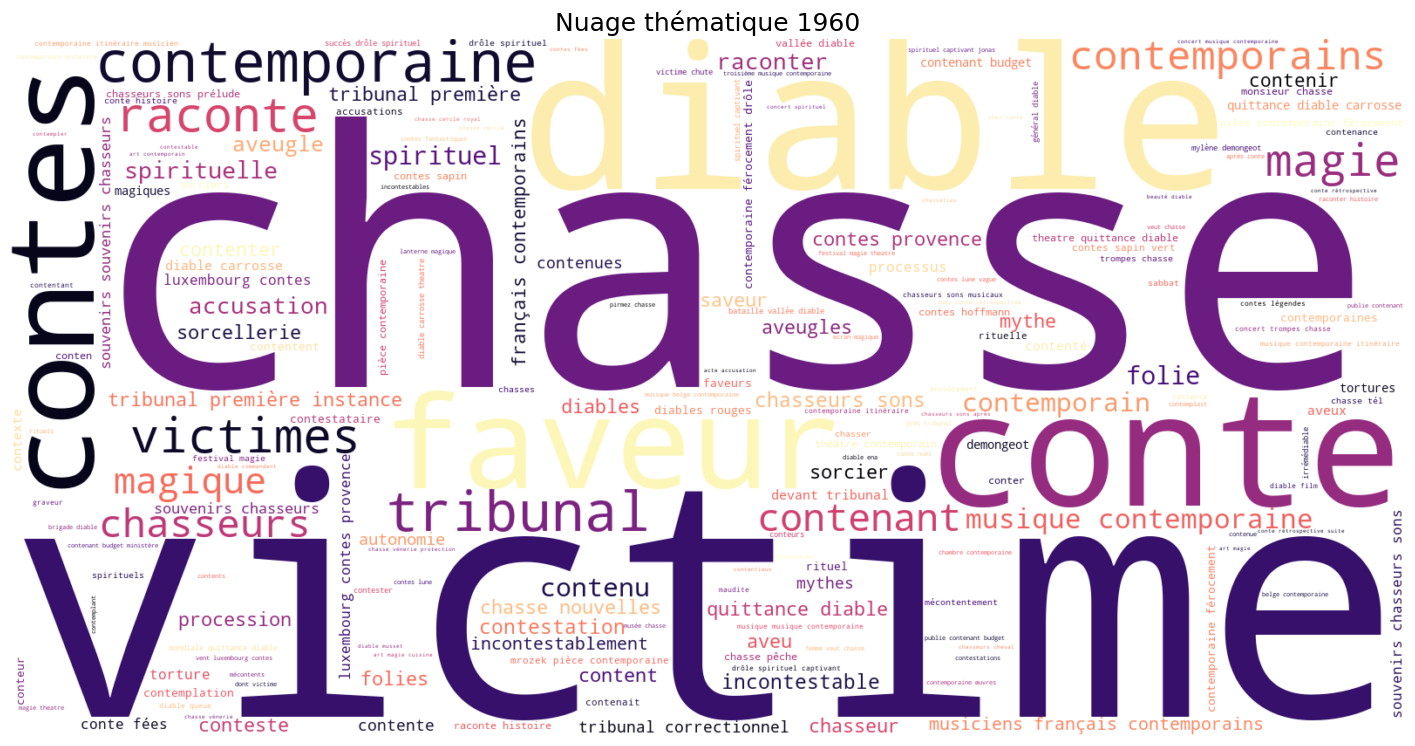


Analyse n-grammes — 1970
Top 20 : [('victimes', 20), ('chasse', 15), ('contemporaine', 13), ('raconte', 11), ('victime', 11), ('conte', 10), ('diable', 10), ('tribunal', 9), ('faveur', 8), ('magique', 8), ('musique contemporaine', 8), ('spirituel', 7), ('aveu', 5), ('aveugle', 5), ('contenant', 5), ('contenu', 5), ('tribunal correctionnel', 5), ('chasseurs', 4), ('contemporain', 4), ('contes', 4)]


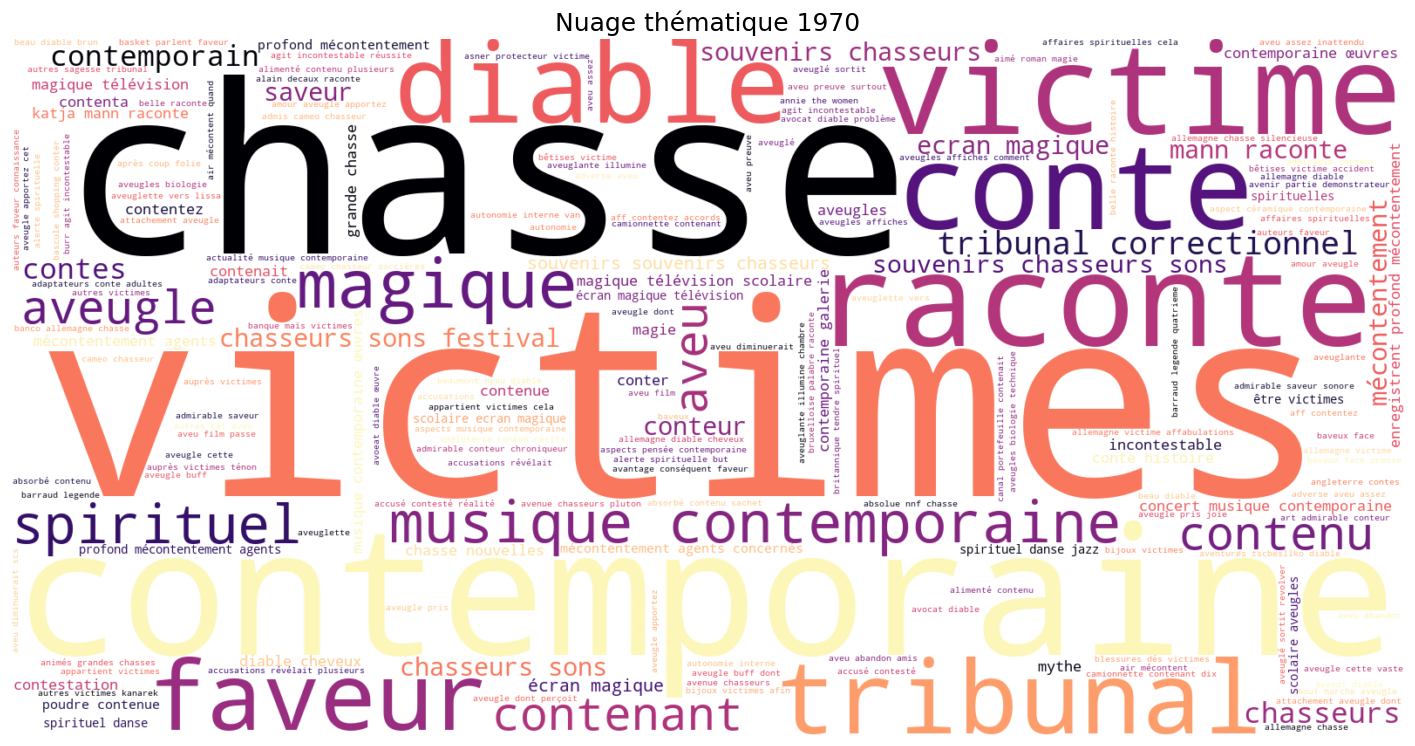


Analyse n-grammes — 1950
Top 20 : [('chasse', 243), ('diable', 191), ('tribunal', 153), ('faveur', 145), ('victime', 144), ('contenant', 117), ('victimes', 107), ('magie', 102), ('folie', 86), ('conte', 79), ('magique', 78), ('chasseur', 65), ('diables', 64), ('contenance', 62), ('spirituel', 58), ('raconte', 50), ('spirituelle', 49), ('contes', 44), ('aveu', 43), ('contemporaine', 41)]


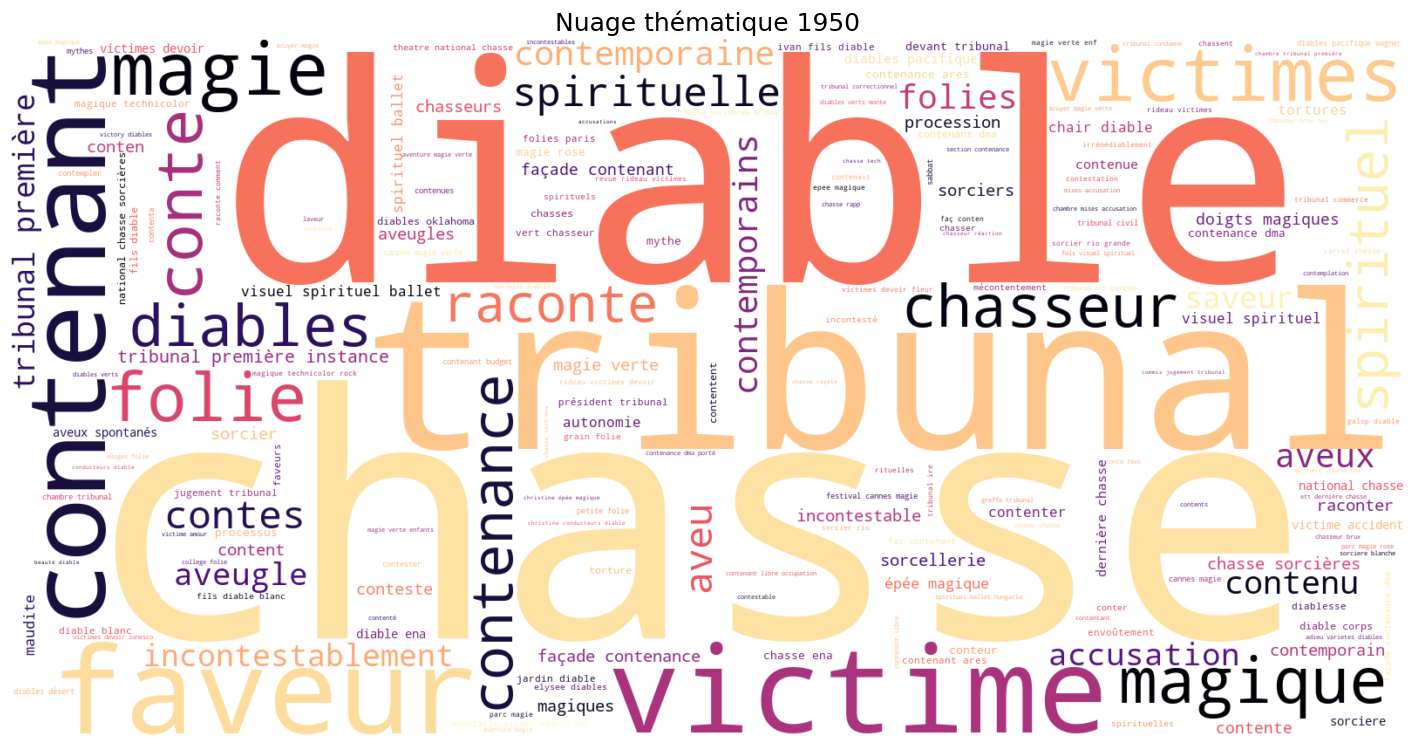

In [6]:
# ------------------------------------------------------------
# ANALYSE N-GRAMMES PAR DÉCENNIE
# ------------------------------------------------------------

for dec, texts in corpus_decennies.items():
    print(f"\nAnalyse n-grammes — {dec}")

    comb = " ".join(texts)

    vect = CountVectorizer(ngram_range=(1,3), stop_words=list(stopwords_custom))
    X = vect.fit_transform([comb])

    feats = vect.get_feature_names_out()
    counts = X.toarray()[0]

    ngram_counts = {
        feats[i]: counts[i]
        for i in range(len(feats))
        if any(cible in feats[i] for cible in mots_cibles)
    }

    top_items = sorted(ngram_counts.items(), key=lambda x: x[1], reverse=True)[:70]

    print("Top 20 :", top_items[:20])

    # Wordcloud
    if ngram_counts:
        cloud = WordCloud(
            width=1600, height=800,
            background_color="white",
            colormap="magma"
        ).generate_from_frequencies(ngram_counts)

        plt.figure(figsize=(18,10))
        plt.imshow(cloud, interpolation="bilinear")
        plt.axis("off")
        plt.title(f"Nuage thématique {dec}", fontsize=18)
        plt.savefig(f"{output_dir}/nuage_{dec}.png", dpi=300, bbox_inches="tight")
        plt.show()


In [ ]:
# ------------------------------------------------------------
# TF-IDF GLOBAL
# ------------------------------------------------------------

print("\nCalcul TF-IDF global…")

documents = [" ".join(filtrer_mots(nettoyer_texte(open(os.path.join(data_path,f),'r',encoding='utf-8').read()).split()))
             for f in files]

vectorizer = TfidfVectorizer(max_features=100)
X = vectorizer.fit_transform(documents)

scores = dict(zip(vectorizer.get_feature_names_out(),
                  X.toarray().mean(axis=0)))

top_tfidf = sorted(scores.items(), key=lambda x: x[1], reverse=True)[:50]

print("Top TF-IDF :", top_tfidf)

Décennies : [1950, 1960, 1970]
Taille corpus global : 2510665

Analyse n-grammes — 1960
Top 20 : [('chasse', 225), ('victime', 201), ('diable', 198), ('conte', 179), ('faveur', 150), ('contes', 132), ('contemporaine', 125), ('tribunal', 119), ('raconte', 90), ('victimes', 90), ('magie', 76), ('contemporains', 71), ('chasseurs', 69), ('contenant', 67), ('magique', 61), ('musique contemporaine', 59), ('contenu', 56), ('contemporain', 55), ('folie', 53), ('spirituel', 52)]


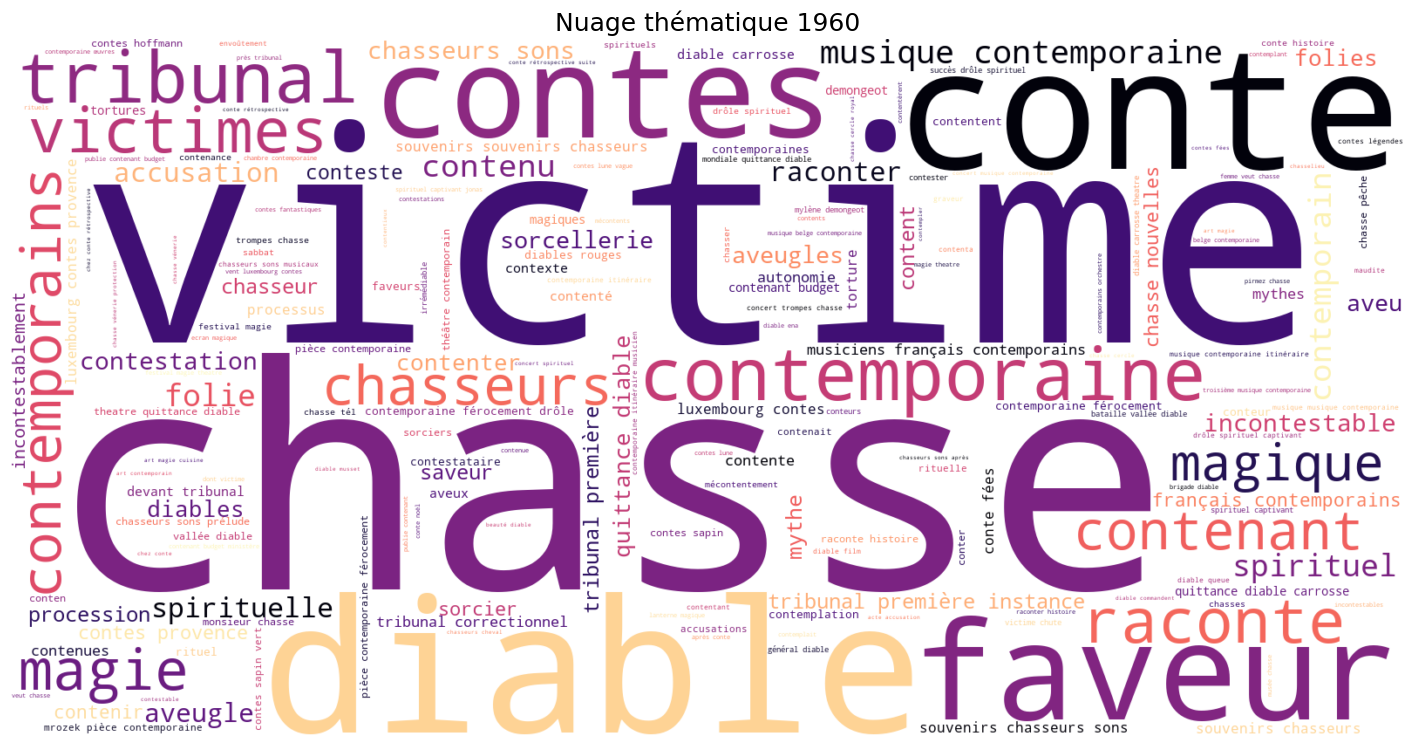


Analyse n-grammes — 1970
Top 20 : [('victimes', 20), ('chasse', 15), ('contemporaine', 13), ('raconte', 11), ('victime', 11), ('conte', 10), ('diable', 10), ('tribunal', 9), ('faveur', 8), ('magique', 8), ('musique contemporaine', 8), ('spirituel', 7), ('aveu', 5), ('aveugle', 5), ('contenant', 5), ('contenu', 5), ('tribunal correctionnel', 5), ('chasseurs', 4), ('contemporain', 4), ('contes', 4)]


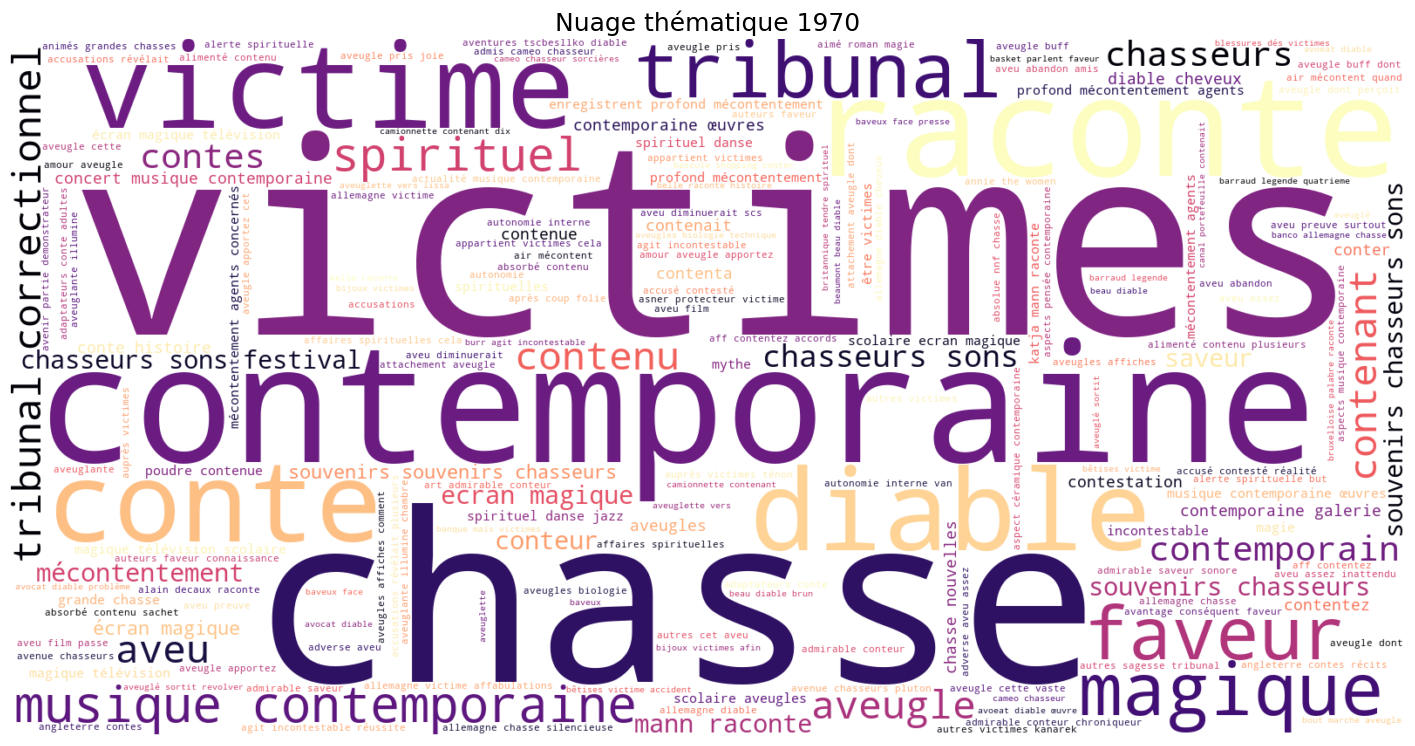


Analyse n-grammes — 1950
Top 20 : [('chasse', 243), ('diable', 191), ('tribunal', 153), ('faveur', 145), ('victime', 144), ('contenant', 117), ('victimes', 107), ('magie', 102), ('folie', 86), ('conte', 79), ('magique', 78), ('chasseur', 65), ('diables', 64), ('contenance', 62), ('spirituel', 58), ('raconte', 50), ('spirituelle', 49), ('contes', 44), ('aveu', 43), ('contemporaine', 41)]


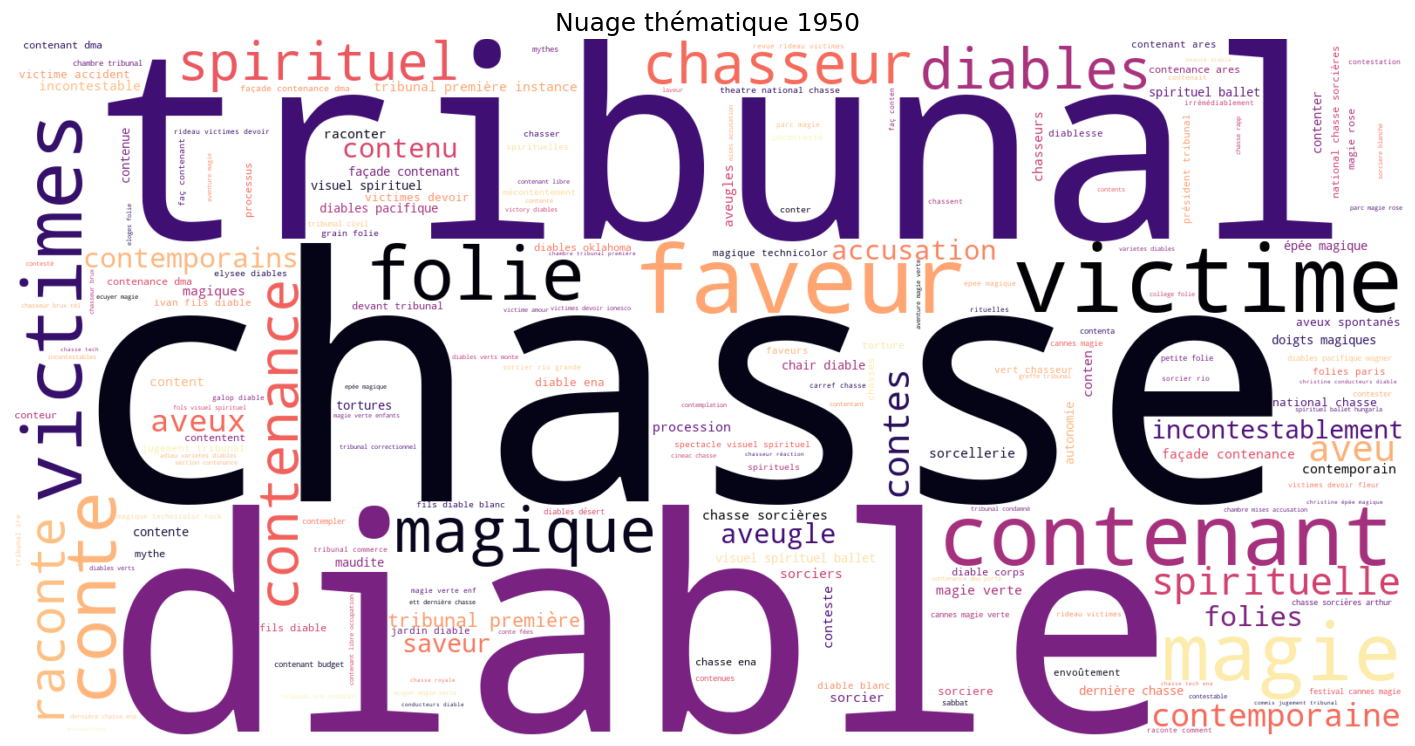


Calcul TF-IDF global…
Top TF-IDF : [('plus', 0.2226628653397992), ('musique', 0.1587179184121545), ('ena', 0.14885317644452978), ('tél', 0.1436416759986123), ('cette', 0.1352905277903703), ('film', 0.10111301103754103), ('deux', 0.09982146191732622), ('être', 0.08305809187963153), ('dont', 0.08005072020863362), ('prix', 0.07652623245083567), ('enf', 0.07382556267945384), ('van', 0.07171283137688025), ('très', 0.07170777467789334), ('après', 0.07119343365207817), ('concert', 0.07106536508115743), ('france', 0.06355390412716506), ('théâtre', 0.06319953357079568), ('orchestre', 0.06294690928480033), ('theatre', 0.06153704782223333), ('maison', 0.06044934758832061), ('leurs', 0.05977263398760532), ('contre', 0.053290433553391935), ('belgique', 0.05269327218877038), ('admis', 0.052653071095044975), ('journal', 0.052436518648919433), ('autres', 0.05128837761461737), ('premier', 0.05117040179425873), ('jean', 0.050897334668092105), ('enfants', 0.04964511366538215), ('paris', 0.04939402099549

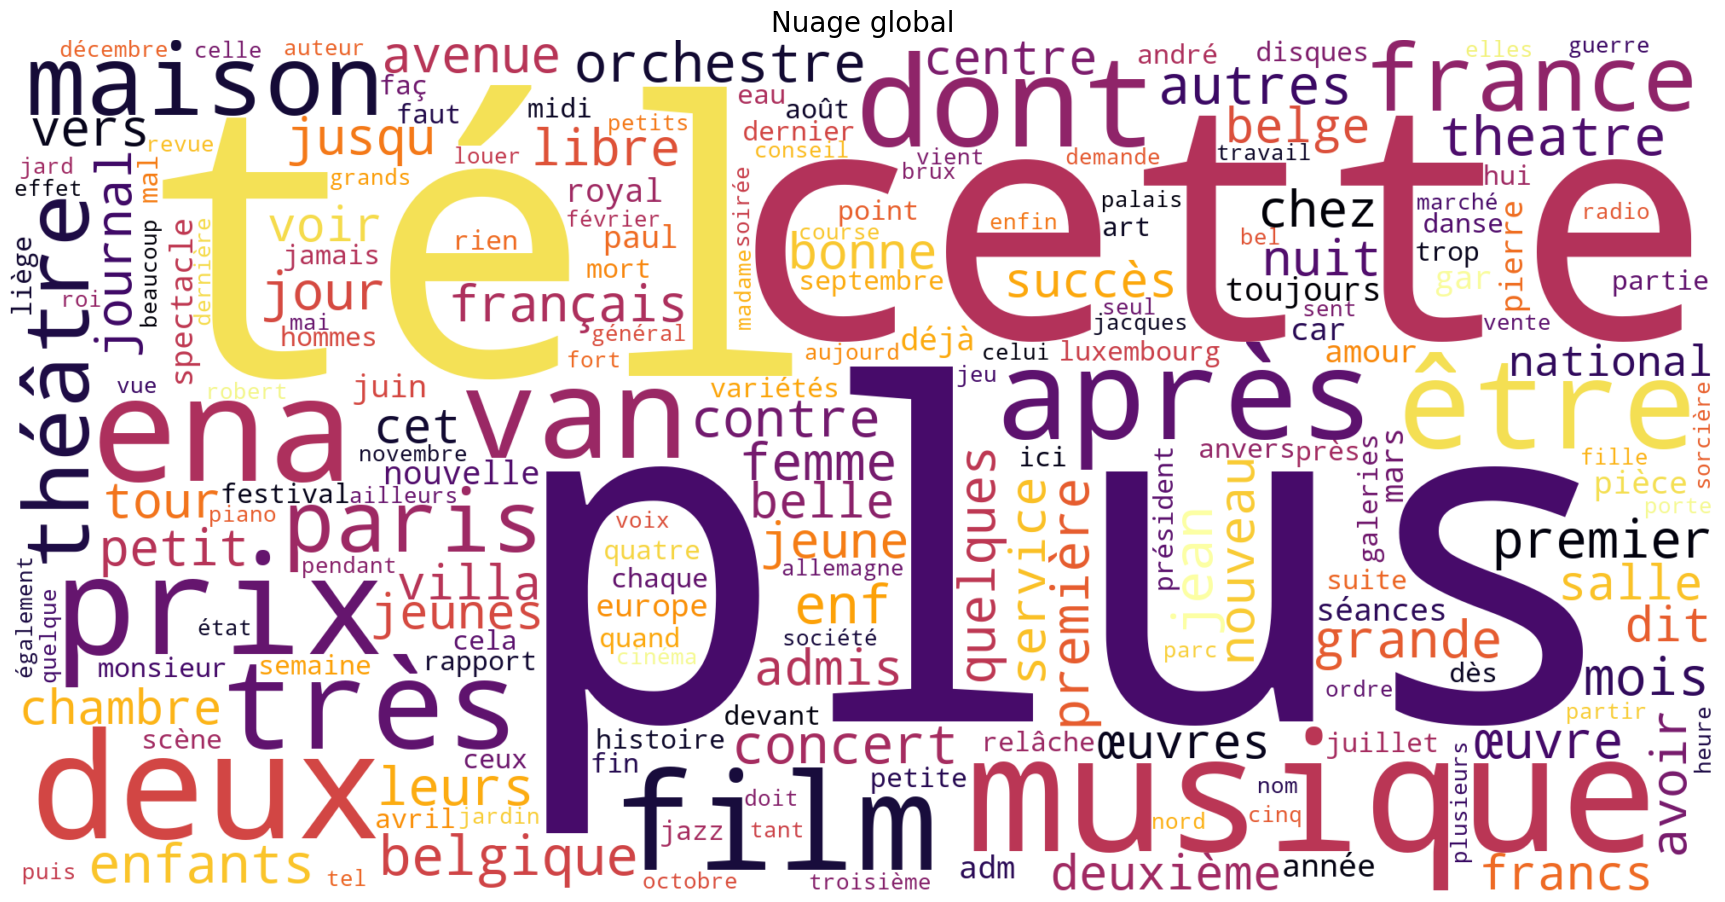


Analyse terminée.


In [1]:
# ------------------------------------------------------------
# CLOUD GLOBAL
# ------------------------------------------------------------

freq = Counter(corpus)

cloud = WordCloud(
    width=2000, height=1000,
    background_color="white",
    colormap="inferno"
).generate_from_frequencies(freq)

plt.figure(figsize=(22,12))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage global", fontsize=20)
plt.show()

print("\nAnalyse terminée.")
